In [49]:
#!jupyter nbconvert --ClearOutputPreprocessor.enabled=True --inplace dsn_final.ipynb

In [1]:

import numpy as np
import pandas as pd
from numpy import mean
from tempfile import mkdtemp
import os.path as path
import time
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.decomposition import PCA
from catboost import Pool,CatBoostClassifier
import xgboost as xgb
from sklearn import  metrics   #Additional scklearn functions
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
import os

import random as rn
import matplotlib.pyplot as plt#visualization
from PIL import  Image
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import auc, roc_auc_score,roc_curve,scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import average_precision_score, precision_score,recall_score,precision_recall_curve
from yellowbrick.classifier import DiscriminationThreshold

#nueral networks
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler,StandardScaler


In [2]:
# manual parameters
RANDOM_SEED = 42
# setting random seeds for libraries to ensure reproducibility
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)

In [3]:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)

In [4]:
#%cd gdrive/My\ Drive/dsn-final
#%ls


In [5]:
def load_train():
    data = pd.read_csv('Train.csv')
    #set yes  to 1, no to 0
    data['default_status'] = data['default_status'].map({'yes': 1, 'no': 0}) 
    #label
    y = data[['default_status']]
    #y = np.ravel(y)
    #features
    X = data.iloc[:,1:-1]
    return data,X,y
    
    
    

In [6]:
def load_test():
    test_data = pd.read_csv('Test.csv')
    test_data.head()
    test_data = test_data.iloc[:,1:]
    return test_data

In [7]:
def show_insights(data):
    print ("Rows     : " ,data.shape[0])
    print ("Columns  : " ,data.shape[1])
    print ("\nFeatures : \n" ,data.columns.tolist())
    print ("\nMissing values :  \n", data.isnull().sum())
    print ("\nTotal missing values :  ", data.isnull().sum().values.sum())
    print ("\nUnique values :  \n",data.nunique())

In [8]:
def scale_data(X,test_data):
    rb = RobustScaler()
    X_train_scaled = rb.fit_transform(X)
    test_data_scaled = rb.transform(test_data)
    return X_train_scaled, test_data_scaled

In [9]:
class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = SimpleImputer(strategy=impute_strategy)

    def fit(self, X,y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X,y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X,self.imputer,self.thresh)

    @staticmethod
    def calculate_vif(X,imputer,thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X,imputer

In [10]:
def run_vif(X,y,test_data):
    X_pd = pd.get_dummies(X, columns = ['form_field47'])
    test_data = pd.get_dummies(test_data, columns = ['form_field47'])
    transformer = ReduceVIF()
    X_vif,imputer = transformer.fit_transform(X_pd,y)
    #impute test_data
    columns = test_data.columns.tolist()
    test_data_pd = pd.DataFrame(imputer.transform(test_data), columns=columns)
    
    test_vif = pd.DataFrame()
    new_features = X_vif.columns.tolist()
    for new_feature, column in zip(new_features, test_data_pd.columns):
        if new_feature == column:
             test_vif[new_feature] = test_data_pd[column]
    X_vif.to_csv('X_vif.csv',index=False)
    test_vif.to_csv('test_vif.csv',index=False)
                               
    return X_vif,test_vif

In [11]:
def select_best_features(X,y,test_data,n_features=40):
   
    print(f'-----------selecting best features-----------')
    X_copy = X.fillna(0)
    X_copy = pd.get_dummies(X_copy)
    
    test_copy = test_data.fillna(0)
    test_copy = pd.get_dummies(test_copy)
    
    
    X_copy,test_data_scaled = scale_data(X_copy,test_copy)
        
    #pca = PCA(n_components=n_features)
    #X_pca = pca.fit_transform(X)
    #test_data_pca = pca.transform(test_data)
    #return X_pca, test_data_pca

    feature_names = list(X.columns.values)
    # define feature selection 
    fs = SelectKBest(score_func=f_classif,  k=n_features)
    # apply feature selection
    selected = fs.fit_transform(X_copy, y)
    mask = fs.get_support() #list of booleans
    new_features = [] # The list of K best features

    for bool, feature in zip(mask, feature_names):
        if bool:
            new_features.append(feature)

    #After that,update the name of features:
    X_selected =X[new_features]
    test_selected = test_data[new_features]
    return X_selected, test_selected

In [12]:
def preprocess_data_knn(X,y,test_data):
    data = X.drop(['form_field50','form_field10'],axis=1)
    test_data = test_data.drop(['form_field50','form_field10'],axis=1)

    labelencoder = LabelEncoder()
    data['form_field47'] = labelencoder.fit_transform(data['form_field47'])
    
    test_data['form_field47'] = labelencoder.transform(test_data['form_field47'])
    
    #measures for memory management
    data_fname = path.join(mkdtemp(), 'train.dat') 
    tdata_fname = path.join(mkdtemp(), 'test.dat') 
    
    data_fp = np.memmap(data_fname, dtype='float32', mode='w+', shape=data.shape)
    data_fp[:] = data[:]
    
    tdata_fp = np.memmap(tdata_fname, dtype='float32', mode='w+', shape=test_data.shape)
    tdata_fp[:] = test_data[:]

    # define imputer
    imputer = KNNImputer(n_neighbors=5)
    # fit on the dataset
    imputer.fit(data_fp)
    # transform the dataset
    X = imputer.transform(data_fp)
    _test = imputer.transform(tdata_fp)
    
    return X,_test

In [13]:
def save_knn_imputed(X,test_data):
  from numpy import asarray
  from numpy import savetxt
  savetxt('train_prep.csv', X, delimiter=',')
  savetxt('test_prep.csv', test_data, delimiter=',')

In [14]:
def load_knn_imputed():
  X = pd.read_csv('train_prep.csv')
  test_data = pd.read_csv('test_prep.csv')
  return X, test_data

In [15]:
def plot_customer_attrition(data,target):
    #labels
    lab = data[target].value_counts().keys().tolist()
    #values
    val = data[target].value_counts().values.tolist()

    trace = go.Pie(labels = lab ,
                   values = val ,
                   marker = dict(colors =  [ 'royalblue' ,'lime'],
                                 line = dict(color = "white",
                                             width =  1.3)
                                ),
                   rotation = 90,
                   hoverinfo = "label+value+text",
                   hole = .5
                  )
    layout = go.Layout(dict(title = "Customer attrition in data",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                           )
                      )

    data = [trace]
    fig = go.Figure(data = data,layout = layout)
    py.iplot(fig)

In [16]:
def save_prediction(pred_name,pred):
    test_data = pd.read_csv('Test.csv')
    submission = pd.DataFrame()
    submission['Applicant_ID'] = test_data['Applicant_ID']
    submission['default_status'] = pred
    pred_name = pred_name + '.csv'
    submission.to_csv(pred_name, index =False)
    print(f'-------prediction saved as {pred_name}--------')
    

In [17]:
def apply_smote(X,y,test_data, model):

    from sklearn.svm import LinearSVC
    from imblearn import over_sampling as os
    from imblearn import pipeline as pl
    from imblearn.metrics import classification_report_imbalanced

    RANDOM_STATE = 33
    
    #create a pipeline
    pipeline = pl.make_pipeline(os.SMOTE(random_state=RANDOM_STATE),model)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=RANDOM_STATE)

    # Train the classifier with balancing
    pipeline.fit(X_train, y_train)

    # Test the classifier and get the prediction
    pred_bal = pipeline.predict_proba(test_data)[:,1]
    
    # Show the classification report
    print(classification_report_imbalanced(y_test, pred_bal))
    y_pred_proba = pipeline.predict(X_test)
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_bal)
    auc = metrics.roc_auc_score(y_test, y_pred_bal)
    plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()
    
    
    timestr = time.strftime("%Y%m%d-%H%M%S")
    pred_name = 'smote' + timestr
    save_prediction(pred_name, pred_bal)

In [18]:
def plot_roc(fpr, tpr, roc_auc):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve (area = %0.6f)' % roc_auc)
    plt.legend(loc="lower right")
    plt.show()


def plot_pr(recall,precision,average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall: {0:0.6f}'.format(average_precision))
    plt.show()

    
def plot_learning_curve(results,epochs):
    x_axis = range(0, epochs)
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['logloss'], label='logloss-Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='logloss-Test')
    ax.plot(x_axis, results['validation_0']['auc'], label='auc-Train')
    ax.plot(x_axis, results['validation_1']['auc'], label='auc-Test')
    ax.legend()
    plt.ylabel('Log Loss/AUC')
    plt.title('XGBoost Log Loss and AUC evolution')
    plt.show()

In [19]:
def cat_xg_preprocess(X,test,strategy='median'):
    X = pd.get_dummies(X,columns=['form_field47'])
    test = pd.get_dummies(test,columns=['form_field47'])
    #impute missing values
    columns = X.columns.tolist()
    imputer = SimpleImputer(strategy = strategy)
    imputer.fit(X)
    X = pd.DataFrame(imputer.transform(X), columns=columns)
    test = pd.DataFrame(imputer.transform(test), columns=columns)
  
    return X,test

In [20]:
def run_catboost_and_calulate_auc(X,y,test_data,learning_rate=0.01):
    
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=33)
    '''
    fold=StratifiedKFold(n_splits=5,shuffle=True,random_state=33)

    for train_index, test_index in fold.split(X,y):
        #for i, (train_index, test_index) in enumerate(fold.split(X,y)):
        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]
        _train = Pool(X_train, label = y_train)
        _valid = Pool(X_val, label = y_val)
        '''
    _train = Pool(X_train, label = y_train)
     
    _valid = Pool(X_test, label = y_test)
    best_params={
    'bagging_temperature': 0.41010395885331385,
    'border_count': 50,
    'depth': 7,
    'iterations': 1000,
    'l2_leaf_reg': 21,
    'random_seed':33,
    'od_wait':100,
    'learning_rate': learning_rate,
    'random_strength': 3.230824361824754e-06,
    'scale_pos_weight': 0.7421091918485163,
    'eval_metric':'AUC'
    }
    
    model = CatBoostClassifier(**best_params,od_type='Iter')
    model.fit(_train,eval_set = _valid, verbose=True)
    
    #make prediction    
    pred = model.predict_proba(test_data)[:,1]
    #save prediction
    timestr = time.strftime("%Y%m%d-%H%M%S")
    pred_name = 'catboost' + timestr
    save_prediction( pred_name, pred)


In [31]:
def run_xgboost_and_calculate_auc(X,
                                  y,
                                  test_data,
                                  target='target',
                                  w=1,
                                  plot_variables=True,
                                  plot_ROC_PR=True,
                                  plot_confusion=True,
                                  plot_graph_tree=False,
                                  learning_rate=0.05,
                                  max_depth=4,
                                  esr=10,
                                  CV=False,
                                  plot_all=False,
                                  ensembler=False,
                                  smote=False,
                                  test_size=.2):

    #X = X.loc[:,~X.columns.duplicated()]
  


    X_train, X_test, Y_train, Y_test = train_test_split(X, y,
                                                        test_size=test_size,
                                                        random_state=33,
                                                        stratify=y)
    
    if smote:

        smote = SMOTE(random_state=33, ratio = 1.0)
        X_train, Y_train = smote.fit_sample(X_train, Y_train)
  

    
        
    clf = xgb.XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=1000,
        max_depth=4,
        min_child_weight=1,
        gamma=0.2,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=5e-05,
        objective='binary:logistic',
        nthread=20,
        scale_pos_weight=w,
        seed=27)
    
    
    eval_set = [(X_train, Y_train), (X_test, Y_test)]

    if plot_all:
        plot_learning=True
        plot_variables=True
        plot_ROC_PR=True
        plot_confusion=True
        plot_graph_tree=True
        
    if CV:
        X = np.concatenate([X_train,X_test])
        y = np.concatenate([Y_train,Y_test])
        xgb_param = clf.get_xgb_params()
        xgtrain = xgb.DMatrix(X, y)
        cvresult = xgb.cv(xgb_param,
                          xgtrain,
                          num_boost_round=clf.get_params()['n_estimators'],
                          nfold=5,
                          metrics='auc',
                          early_stopping_rounds=esr)
        print(cvresult.tail(1))
        clf.set_params(n_estimators=cvresult.shape[0])

    clf.fit(X_train,
            Y_train,
            early_stopping_rounds=25,
            eval_metric=['auc'],
            eval_set=eval_set,
            verbose=True)
    
    from sklearn.ensemble import AdaBoostClassifier
    tree = DecisionTreeClassifier(criterion='entropy')
    booster = AdaBoostClassifier(base_estimator=tree)
    booster = booster.fit(X_test, Y_test)
    
    Y_pred = clf.predict_proba(X_test)
    y_true = np.array(Y_test)
    y_scores = Y_pred[:, 1]

    fpr, tpr, _ = roc_curve(Y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    average_precision = average_precision_score(Y_test, y_scores)
    precision, recall, _ = precision_recall_curve(Y_test, y_scores)
    
    if plot_ROC_PR:
        plot_roc(fpr, tpr, roc_auc)
        plot_pr(recall,precision,average_precision)
    else:
        print('Area under ROC: %0.6f' % roc_auc)

    if plot_graph_tree:
        xgb.plot_tree(clf, rankdir='LR')
        fig = plt.gcf()
        fig.set_size_inches(150, 100)

    if plot_variables:
        xgb.plot_importance(clf,max_num_features=20,importance_type='gain',xlabel='gain')

    if plot_confusion:
        print('\n', classification_report(y_true, y_scores.round()))
        
    if ensembler:
        return Y_test, y_scores

    print('-------------END EXECUTION-------------')
    
    #test_data = xgb.DMatrix(test_data)
    pred = clf.predict_proba(test_data)[:,1]
    
    timestr = time.strftime("%Y%m%d-%H%M%S")
    pred_name = 'xgboost'+timestr
    save_prediction(pred_name, pred)
    
  

In [32]:
def run_nn_and_calculate_auc(X,y,test_data,input_dim,batch_size,epochs):
    model = Sequential()
    model.add(Dense(input_dim,input_dim=input_dim,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=Adam(), metrics= tf.keras.metrics.AUC(name='auc'))
    model.fit(X,y,epochs=epochs,batch_size=batch_size)
    
    #predict
    pred = model.predict(test_data)
    
    #save prediction
    timestr = time.strftime("%Y%m%d-%H%M%S")
    pred_name = 'nn'+timestr
    save_prediction(pred_name, pred)
    

In [33]:
data,X,y = load_train()
test_data = load_test()
show_insights(data)
data.head()

Rows     :  56000
Columns  :  52

Features : 
 ['Applicant_ID', 'form_field1', 'form_field2', 'form_field3', 'form_field4', 'form_field5', 'form_field6', 'form_field7', 'form_field8', 'form_field9', 'form_field10', 'form_field11', 'form_field12', 'form_field13', 'form_field14', 'form_field15', 'form_field16', 'form_field17', 'form_field18', 'form_field19', 'form_field20', 'form_field21', 'form_field22', 'form_field23', 'form_field24', 'form_field25', 'form_field26', 'form_field27', 'form_field28', 'form_field29', 'form_field30', 'form_field31', 'form_field32', 'form_field33', 'form_field34', 'form_field35', 'form_field36', 'form_field37', 'form_field38', 'form_field39', 'form_field40', 'form_field41', 'form_field42', 'form_field43', 'form_field44', 'form_field45', 'form_field46', 'form_field47', 'form_field48', 'form_field49', 'form_field50', 'default_status']

Missing values :  
 Applicant_ID          0
form_field1        2529
form_field2        3844
form_field3         355
form_field

,Applicant_ID,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,...,form_field42,form_field43,form_field44,form_field45,form_field46,form_field47,form_field48,form_field49,form_field50,default_status
0,Apcnt_1000000,3436.0,0.28505,1.6560,0.0,0.000,0.0,10689720.0,252072.0,4272776.0,...,0.392854,2.02,0.711632,0.0,0.0,charge,NaN,1.129518,0.044335,0
1,Apcnt_1000004,3456.0,0.67400,0.2342,0.0,0.000,0.0,898979.0,497531.0,9073814.0,...,0.314281,8.08,0.183584,NaN,0.0,charge,349.805730,1.620483,0.322436,0
2,Apcnt_1000008,3276.0,0.53845,3.1510,0.0,6.282,NaN,956940.0,NaN,192944.0,...,0.162965,18.18,0.791136,0.0,0.0,charge,NaN,1.513370,0.011640,1
3,Apcnt_1000012,3372.0,0.17005,0.5050,0.0,0.000,192166.0,3044703.0,385499.0,3986472.0,...,0.488884,2.02,0.685168,NaN,0.0,charge,89.940100,0.664452,0.082729,0
4,Apcnt_1000016,3370.0,0.77270,1.1010,0.0,0.000,1556.0,214728.0,214728.0,1284089.0,...,0.275000,12.12,0.438168,0.0,0.0,charge,97.887502,1.427891,0.045630,0


In [34]:
#Description of dataset
print(data.describe)

<bound method NDFrame.describe of         Applicant_ID  form_field1  form_field2  form_field3  form_field4  \
0      Apcnt_1000000       3436.0      0.28505       1.6560       0.0000   
1      Apcnt_1000004       3456.0      0.67400       0.2342       0.0000   
2      Apcnt_1000008       3276.0      0.53845       3.1510       0.0000   
3      Apcnt_1000012       3372.0      0.17005       0.5050       0.0000   
4      Apcnt_1000016       3370.0      0.77270       1.1010       0.0000   
...              ...          ...          ...          ...          ...   
55995   Apcnt_999968       3740.0      0.01730       0.0000       0.0000   
55996   Apcnt_999972       3360.0      2.01145       0.6252       0.0000   
55997   Apcnt_999980       3500.0      0.76640       0.0000       0.0000   
55998   Apcnt_999988       3280.0      0.05235       2.0916       2.2212   
55999   Apcnt_999996       3522.0      0.46930       0.0000       0.0000   

       form_field5  form_field6  form_field7  form_fi

In [48]:
#Customer attrition in data
data_cpy = data.fillna(0)
#Separating defaulted and non defaulted customers
defaulted     = data_cpy[data_cpy["default_status"] == 1]
non_defaulted = data_cpy[data_cpy["default_status"] == 0]

#Separating catagorical and numerical columns
Id_col     = ['Applicant_ID']
target_col = ["default_status"]
cat_cols   = data.select_dtypes('object').keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in data_cpy.columns if x not in cat_cols + target_col + Id_col]

plot_customer_attrition(data_cpy,target = 'default_status')

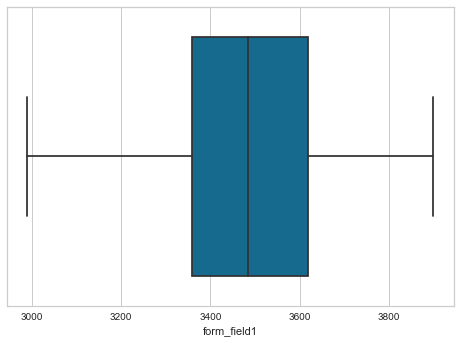

In [28]:
sns.boxplot(x=X['form_field1'])

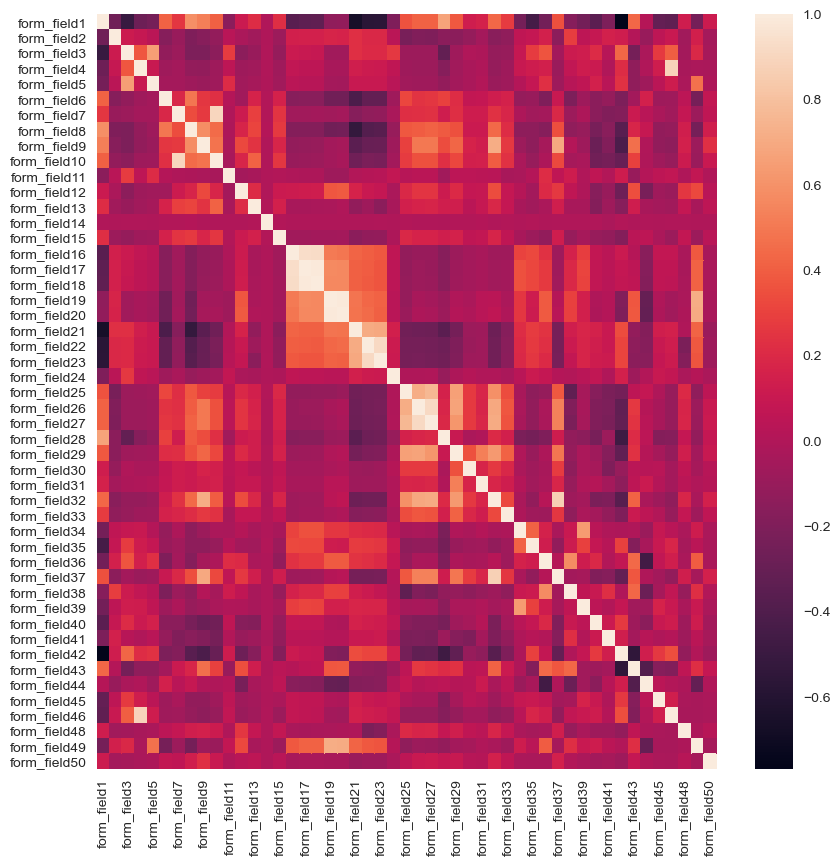

In [32]:
#plot heatmap
plt.figure(figsize= (10,10), dpi=100)
sns.heatmap(X.corr())


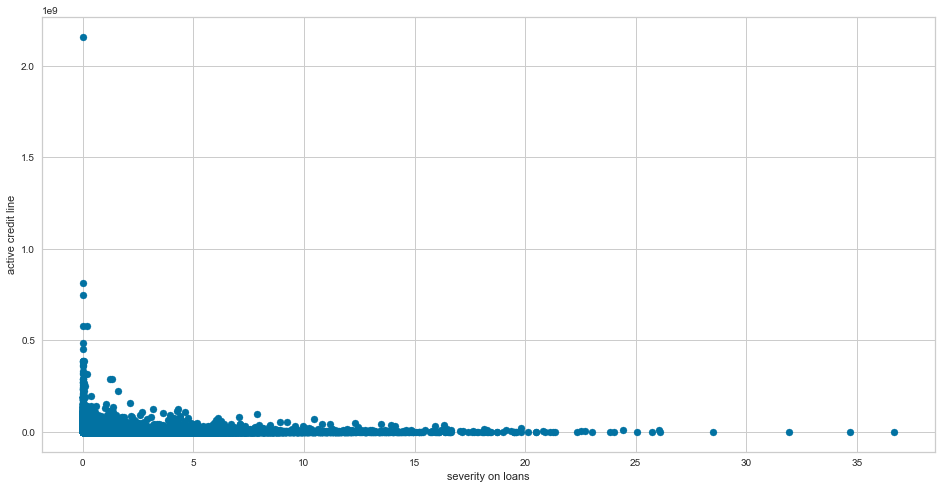

In [86]:
    
#scatter plot
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(X['form_field3'], X['form_field7'])
ax.set_xlabel('severity on loans')
ax.set_ylabel('active credit line')
plt.show()
    

In [19]:
# run knn imputation function
X_prep, test_data_prep = preprocess_data_knn(X,y,test_data)
save_knn_imputed(X_prep,test_data_prep)

In [21]:
X_prep

array([[3.4360000e+03, 2.8505000e-01, 1.6560000e+00, ..., 0.0000000e+00,
        3.3085291e+02, 1.1295180e+00],
       [3.4560000e+03, 6.7400002e-01, 2.3420000e-01, ..., 0.0000000e+00,
        3.4980573e+02, 1.6204829e+00],
       [3.2760000e+03, 5.3845000e-01, 3.1510000e+00, ..., 0.0000000e+00,
        3.3655022e+01, 1.5133703e+00],
       ...,
       [3.5000000e+03, 7.6639998e-01, 0.0000000e+00, ..., 1.0000000e+00,
        1.2524745e+03, 2.0000000e+00],
       [3.2800000e+03, 5.2350000e-02, 2.0915999e+00, ..., 0.0000000e+00,
        5.2505186e+03, 0.0000000e+00],
       [3.5220000e+03, 4.6930000e-01, 0.0000000e+00, ..., 0.0000000e+00,
        4.9861885e+03, 3.0000000e+00]], dtype=float32)

In [ ]:

# run vif reduction function
X_vif,sel_test = run_vif(X,y,test_data)

In [58]:
X_vif

,form_field2,form_field3,form_field5,form_field6,form_field7,form_field8,form_field9,form_field11,form_field12,form_field13,...,form_field35,form_field37,form_field38,form_field39,form_field42,form_field45,form_field46,form_field48,form_field50,form_field47_charge
0,0.28505,1.6560,0.000,0.0,10689720.0,252072.0,4272776.0,4397256.0,2301324.0,7875694.0,...,0.0,12.0,4.0,0.0,0.392854,0.0,0.0,318.124292,0.044335,1.0
1,0.67400,0.2342,0.000,0.0,898979.0,497531.0,9073814.0,244292.0,3982971.0,2141445.0,...,0.0,24.0,8.0,0.0,0.314281,0.0,0.0,349.805730,0.322436,1.0
2,0.53845,3.1510,6.282,115533.0,956940.0,963942.0,192944.0,698644.0,1163110.0,0.0,...,0.0,0.0,6.0,0.0,0.162965,0.0,0.0,318.124292,0.011640,1.0
3,0.17005,0.5050,0.000,192166.0,3044703.0,385499.0,3986472.0,698644.0,771776.0,1186839.0,...,1.0,8.0,4.0,1.0,0.488884,0.0,0.0,89.940100,0.082729,1.0
4,0.77270,1.1010,0.000,1556.0,214728.0,214728.0,1284089.0,396391.0,818456.0,511535.0,...,0.0,2.0,24.0,0.0,0.275000,0.0,0.0,97.887502,0.045630,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55995,0.01730,0.0000,0.000,770998.0,9637475.0,4047934.0,11641992.0,698644.0,983003.0,25985589.0,...,0.0,8.0,8.0,0.0,0.000000,0.0,0.0,591.048913,0.241598,0.0
55996,2.01145,0.6252,0.000,115533.0,927765.0,963942.0,5506295.0,571052.0,1163110.0,0.0,...,0.0,0.0,34.0,0.0,0.297913,0.0,0.0,318.124292,0.170400,0.0
55997,0.76640,0.0000,0.000,118645.0,3662435.0,3662435.0,3585024.0,698644.0,2765401.0,4226874.0,...,0.0,0.0,4.0,0.0,0.550000,0.0,0.0,1252.474467,0.163153,0.0
55998,0.05235,2.0916,0.000,115533.0,3458599.0,963942.0,115533.0,508812.0,1163110.0,0.0,...,0.0,2.0,8.0,1.0,0.942854,1.0,0.0,318.124292,0.002997,1.0


In [93]:
#transform test_data columns with the processed train data
test_data_dm = pd.get_dummies(test_data,columns=['form_field47'])
test_vif = pd.DataFrame()
new_features = X_vif.columns.tolist()
for new_feature in new_features:
    for column in test_data_dm.columns:
        if new_feature == column:
            test_vif[new_feature] = test_data_dm[column]
test_vif = test_vif.fillna(test_vif.median())

In [96]:
test_vif

,form_field2,form_field3,form_field5,form_field6,form_field7,form_field8,form_field9,form_field11,form_field12,form_field13,...,form_field35,form_field37,form_field38,form_field39,form_field42,form_field45,form_field46,form_field48,form_field50,form_field47_charge
0,0.34875,10.2006,0.0000,418564.0,418564.0,418564.0,540710.0,1649749.0,5446.0,0.0,...,0.0,2.0,14.0,0.0,0.825000,0.0,0.0,313.175396,0.011221,1
1,1.27360,2.9606,0.0000,0.0,9858816.0,49014.0,1510098.0,622789.0,1025793.0,1396510.0,...,0.0,18.0,14.0,2.0,0.507694,1.0,0.0,313.175396,0.043525,0
2,0.27505,0.0600,0.0000,115533.0,2719888.0,959468.5,5529829.5,118256.0,1149495.0,1563391.0,...,0.0,6.0,0.0,0.0,0.220000,0.0,0.0,313.175396,0.168000,1
3,0.28505,2.8032,0.0000,0.0,473802.0,473802.0,1724437.0,1391064.0,1176725.0,1220293.0,...,1.0,0.0,26.0,0.0,0.916663,0.0,0.0,90.163742,0.104029,1
4,2.09545,0.8318,0.0000,19839.0,1150662.0,1150662.0,7860523.0,271133.0,613064.0,4779643.0,...,0.0,28.0,20.0,0.0,0.234047,0.0,0.0,1303.587148,0.163124,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,0.37925,0.5698,0.0000,115533.0,2280318.0,959468.5,5529829.5,1743887.0,1149495.0,0.0,...,0.0,0.0,6.0,0.0,1.100000,0.0,1.0,313.175396,0.168000,1
23996,0.95260,0.0000,0.0000,1494538.0,4773419.0,4773419.0,89718571.0,672775.5,48989882.0,97696961.0,...,0.0,2.0,8.0,0.0,0.000000,0.0,0.0,4200.072959,0.930931,1
23997,0.05755,4.2394,25.4376,115533.0,49403.0,959468.5,5529829.5,215895.0,1149495.0,0.0,...,0.0,4.0,2.0,0.0,1.100000,0.0,0.0,313.175396,0.168000,1
23998,0.75670,1.4428,0.0000,0.0,2513329.0,37733.0,393668.0,121757.0,355935.0,673748.0,...,0.0,0.0,4.0,0.0,0.440000,0.0,0.0,27.325129,0.023749,1


In [36]:
X_pr,test_data_pr = cat_xg_preprocess(X,test_data,strategy = 'constant')

[0]	validation_0-auc:0.79318	validation_1-auc:0.80006
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 25 rounds.
[1]	validation_0-auc:0.80149	validation_1-auc:0.80817
[2]	validation_0-auc:0.80549	validation_1-auc:0.81231
[3]	validation_0-auc:0.80788	validation_1-auc:0.81444
[4]	validation_0-auc:0.80861	validation_1-auc:0.81498
[5]	validation_0-auc:0.81371	validation_1-auc:0.82022
[6]	validation_0-auc:0.81425	validation_1-auc:0.81970
[7]	validation_0-auc:0.81642	validation_1-auc:0.82072
[8]	validation_0-auc:0.81695	validation_1-auc:0.82097
[9]	validation_0-auc:0.81754	validation_1-auc:0.82095
[10]	validation_0-auc:0.81835	validation_1-auc:0.82188
[11]	validation_0-auc:0.81915	validation_1-auc:0.82242
[12]	validation_0-auc:0.81987	validation_1-auc:0.82351
[13]	validation_0-auc:0.82049	validation_1-auc:0.82415
[14]	validation_0-auc:0.82103	validation_1-auc:0.82449
[15]	validation_0-auc:0.8214

[146]	validation_0-auc:0.84854	validation_1-auc:0.84273
[147]	validation_0-auc:0.84869	validation_1-auc:0.84273
[148]	validation_0-auc:0.84887	validation_1-auc:0.84282
[149]	validation_0-auc:0.84896	validation_1-auc:0.84282
[150]	validation_0-auc:0.84909	validation_1-auc:0.84288
[151]	validation_0-auc:0.84925	validation_1-auc:0.84294
[152]	validation_0-auc:0.84943	validation_1-auc:0.84311
[153]	validation_0-auc:0.84951	validation_1-auc:0.84314
[154]	validation_0-auc:0.84965	validation_1-auc:0.84315
[155]	validation_0-auc:0.84977	validation_1-auc:0.84314
[156]	validation_0-auc:0.84985	validation_1-auc:0.84314
[157]	validation_0-auc:0.84994	validation_1-auc:0.84316
[158]	validation_0-auc:0.85007	validation_1-auc:0.84322
[159]	validation_0-auc:0.85023	validation_1-auc:0.84319
[160]	validation_0-auc:0.85035	validation_1-auc:0.84318
[161]	validation_0-auc:0.85045	validation_1-auc:0.84316
[162]	validation_0-auc:0.85063	validation_1-auc:0.84325
[163]	validation_0-auc:0.85075	validation_1-auc:

No handles with labels found to put in legend.


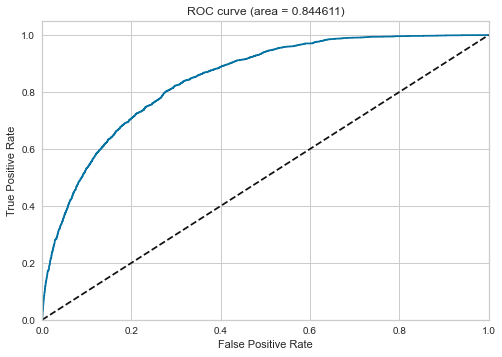

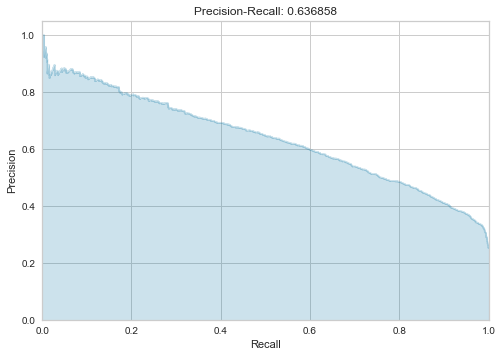


               precision    recall  f1-score   support

           0       0.84      0.93      0.88      8457
           1       0.67      0.44      0.53      2743

    accuracy                           0.81     11200
   macro avg       0.76      0.69      0.71     11200
weighted avg       0.80      0.81      0.80     11200

-------------END EXECUTION-------------
-------prediction saved as xgboost20201004-080424.csv--------


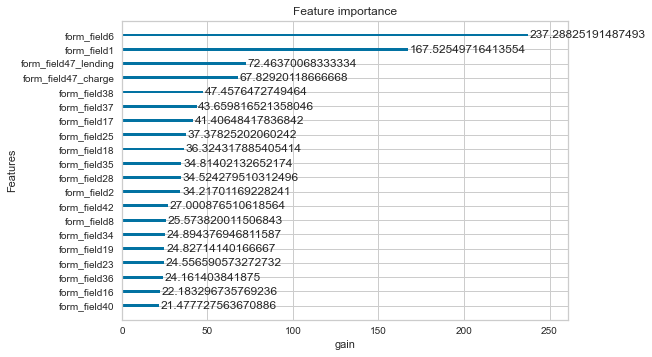

In [40]:

run_xgboost_and_calculate_auc(X_pr,y,test_data_pr,learning_rate=0.04565,CV =False,smote=False)

In [41]:
important_features = ['form_field6','form_field1','form_field47_lending','form_field47_charge','form_field38','form_field37','form_field17','form_field25','form_field18','form_field35','form_field28','form_field2','form_field42','form_field8','form_field34','form_field19','form_field23','form_field36','form_field16','form_field40']

In [42]:
#update data with important features and show the quantile range
X_important = X_pr[important_features]
test_data_important = test_data_pr[important_features]
Q1 = X_important.quantile(0.25)
Q3 = X_important.quantile(0.75)
IQR = Q3 - Q1
print(IQR)
#remove outliers
X_out = X_important[~((X_important < (Q1 - 1.5 * IQR)) |(X_important > (Q3 + 1.5 * IQR))).any(axis=1)]
print(X_out.shape)

form_field6             3.023502e+05
form_field1             2.740000e+02
form_field47_lending    1.000000e+00
form_field47_charge     1.000000e+00
form_field38            8.000000e+00
form_field37            1.200000e+01
form_field17            0.000000e+00
form_field25            2.440500e+03
form_field18            0.000000e+00
form_field35            0.000000e+00
form_field28            6.071200e+04
form_field2             6.280000e-01
form_field42            6.111160e-01
form_field8             2.361230e+06
form_field34            0.000000e+00
form_field19            1.000000e+00
form_field23            5.495734e+03
form_field36            1.000000e+01
form_field16            0.000000e+00
form_field40            0.000000e+00
dtype: float64
(15834, 20)


[0]	validation_0-auc:0.79265	validation_1-auc:0.79949
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 25 rounds.
[1]	validation_0-auc:0.80242	validation_1-auc:0.80870
[2]	validation_0-auc:0.80558	validation_1-auc:0.81103
[3]	validation_0-auc:0.80694	validation_1-auc:0.81233
[4]	validation_0-auc:0.80824	validation_1-auc:0.81422
[5]	validation_0-auc:0.80907	validation_1-auc:0.81460
[6]	validation_0-auc:0.81097	validation_1-auc:0.81606
[7]	validation_0-auc:0.81334	validation_1-auc:0.81779
[8]	validation_0-auc:0.81391	validation_1-auc:0.81828
[9]	validation_0-auc:0.81660	validation_1-auc:0.82050
[10]	validation_0-auc:0.81777	validation_1-auc:0.82150
[11]	validation_0-auc:0.81862	validation_1-auc:0.82235
[12]	validation_0-auc:0.81963	validation_1-auc:0.82283
[13]	validation_0-auc:0.82019	validation_1-auc:0.82335
[14]	validation_0-auc:0.82054	validation_1-auc:0.82351
[15]	validation_0-auc:0.8208

[146]	validation_0-auc:0.84120	validation_1-auc:0.83959
[147]	validation_0-auc:0.84125	validation_1-auc:0.83962
[148]	validation_0-auc:0.84138	validation_1-auc:0.83970
[149]	validation_0-auc:0.84151	validation_1-auc:0.83974
[150]	validation_0-auc:0.84154	validation_1-auc:0.83975
[151]	validation_0-auc:0.84164	validation_1-auc:0.83980
[152]	validation_0-auc:0.84171	validation_1-auc:0.83980
[153]	validation_0-auc:0.84174	validation_1-auc:0.83982
[154]	validation_0-auc:0.84182	validation_1-auc:0.83985
[155]	validation_0-auc:0.84188	validation_1-auc:0.83984
[156]	validation_0-auc:0.84193	validation_1-auc:0.83985
[157]	validation_0-auc:0.84200	validation_1-auc:0.83991
[158]	validation_0-auc:0.84209	validation_1-auc:0.83994
[159]	validation_0-auc:0.84217	validation_1-auc:0.83996
[160]	validation_0-auc:0.84227	validation_1-auc:0.83997
[161]	validation_0-auc:0.84230	validation_1-auc:0.83995
[162]	validation_0-auc:0.84233	validation_1-auc:0.83995
[163]	validation_0-auc:0.84244	validation_1-auc:

[293]	validation_0-auc:0.84989	validation_1-auc:0.84103
[294]	validation_0-auc:0.84996	validation_1-auc:0.84104
[295]	validation_0-auc:0.84997	validation_1-auc:0.84104
[296]	validation_0-auc:0.85001	validation_1-auc:0.84105
[297]	validation_0-auc:0.85005	validation_1-auc:0.84103
[298]	validation_0-auc:0.85007	validation_1-auc:0.84102
[299]	validation_0-auc:0.85016	validation_1-auc:0.84107
Stopping. Best iteration:
[274]	validation_0-auc:0.84901	validation_1-auc:0.84117



No handles with labels found to put in legend.


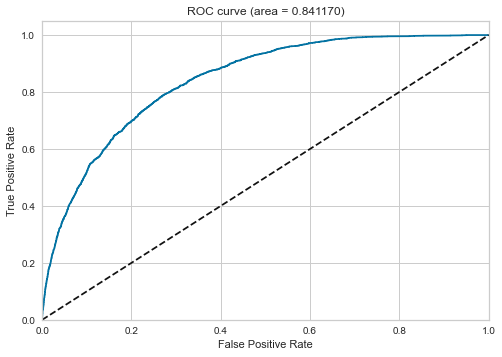

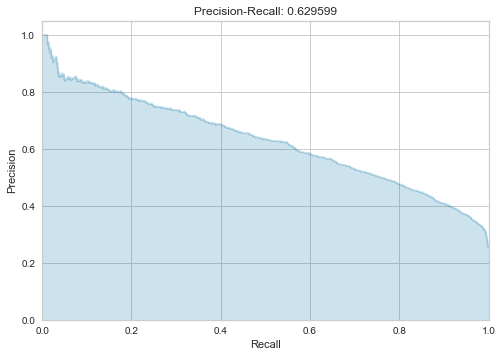


               precision    recall  f1-score   support

           0       0.83      0.93      0.88      8457
           1       0.67      0.43      0.52      2743

    accuracy                           0.81     11200
   macro avg       0.75      0.68      0.70     11200
weighted avg       0.79      0.81      0.79     11200

-------------END EXECUTION-------------
-------prediction saved as xgboost20201004-080535.csv--------


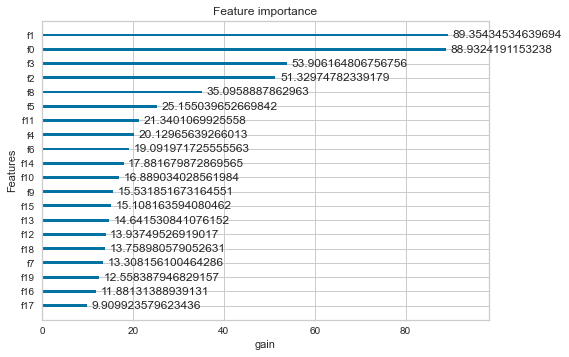

In [43]:
#handle outliers in best features with robust scaler and retrain
rb = RobustScaler()
rb.fit(X_important)
X_important_tr = rb.transform(X_important)
test_data_important_tr = rb.transform(test_data_important)

run_xgboost_and_calculate_auc(X_important_tr,y,test_data_important_tr,learning_rate=0.04565,CV =False,smote=False)

In [120]:
run_catboost_and_calulate_auc(X_important_tr,y,test_data_important_tr,learning_rate=0.05667)

0:	test: 0.8103716	best: 0.8103716 (0)	total: 60ms	remaining: 59.9s
1:	test: 0.8213347	best: 0.8213347 (1)	total: 105ms	remaining: 52.2s
2:	test: 0.8242933	best: 0.8242933 (2)	total: 146ms	remaining: 48.6s
3:	test: 0.8237703	best: 0.8242933 (2)	total: 193ms	remaining: 48.1s
4:	test: 0.8244208	best: 0.8244208 (4)	total: 236ms	remaining: 47s
5:	test: 0.8249940	best: 0.8249940 (5)	total: 301ms	remaining: 49.9s
6:	test: 0.8262394	best: 0.8262394 (6)	total: 366ms	remaining: 51.9s
7:	test: 0.8266602	best: 0.8266602 (7)	total: 444ms	remaining: 55.1s
8:	test: 0.8268646	best: 0.8268646 (8)	total: 504ms	remaining: 55.5s
9:	test: 0.8279597	best: 0.8279597 (9)	total: 602ms	remaining: 59.6s
10:	test: 0.8287483	best: 0.8287483 (10)	total: 670ms	remaining: 1m
11:	test: 0.8294294	best: 0.8294294 (11)	total: 737ms	remaining: 1m
12:	test: 0.8297161	best: 0.8297161 (12)	total: 819ms	remaining: 1m 2s
13:	test: 0.8300401	best: 0.8300401 (13)	total: 876ms	remaining: 1m 1s
14:	test: 0.8303847	best: 0.8303847

118:	test: 0.8378760	best: 0.8378800 (114)	total: 6.96s	remaining: 51.5s
119:	test: 0.8378767	best: 0.8378800 (114)	total: 7.02s	remaining: 51.5s
120:	test: 0.8378893	best: 0.8378893 (120)	total: 7.07s	remaining: 51.3s
121:	test: 0.8378592	best: 0.8378893 (120)	total: 7.12s	remaining: 51.2s
122:	test: 0.8379040	best: 0.8379040 (122)	total: 7.18s	remaining: 51.2s
123:	test: 0.8379004	best: 0.8379040 (122)	total: 7.22s	remaining: 51s
124:	test: 0.8379102	best: 0.8379102 (124)	total: 7.27s	remaining: 50.9s
125:	test: 0.8379031	best: 0.8379102 (124)	total: 7.31s	remaining: 50.7s
126:	test: 0.8379271	best: 0.8379271 (126)	total: 7.37s	remaining: 50.7s
127:	test: 0.8379354	best: 0.8379354 (127)	total: 7.43s	remaining: 50.6s
128:	test: 0.8379474	best: 0.8379474 (128)	total: 7.48s	remaining: 50.5s
129:	test: 0.8379482	best: 0.8379482 (129)	total: 7.53s	remaining: 50.4s
130:	test: 0.8379899	best: 0.8379899 (130)	total: 7.56s	remaining: 50.2s
131:	test: 0.8379512	best: 0.8379899 (130)	total: 7.6

231:	test: 0.8386284	best: 0.8386478 (228)	total: 13.2s	remaining: 43.7s
232:	test: 0.8386251	best: 0.8386478 (228)	total: 13.3s	remaining: 43.6s
233:	test: 0.8386329	best: 0.8386478 (228)	total: 13.3s	remaining: 43.6s
234:	test: 0.8386376	best: 0.8386478 (228)	total: 13.4s	remaining: 43.6s
235:	test: 0.8386085	best: 0.8386478 (228)	total: 13.4s	remaining: 43.5s
236:	test: 0.8386013	best: 0.8386478 (228)	total: 13.5s	remaining: 43.4s
237:	test: 0.8386051	best: 0.8386478 (228)	total: 13.5s	remaining: 43.3s
238:	test: 0.8386174	best: 0.8386478 (228)	total: 13.6s	remaining: 43.2s
239:	test: 0.8386387	best: 0.8386478 (228)	total: 13.6s	remaining: 43.1s
240:	test: 0.8386498	best: 0.8386498 (240)	total: 13.7s	remaining: 43.1s
241:	test: 0.8386719	best: 0.8386719 (241)	total: 13.7s	remaining: 43s
242:	test: 0.8386937	best: 0.8386937 (242)	total: 13.8s	remaining: 43s
243:	test: 0.8386903	best: 0.8386937 (242)	total: 13.9s	remaining: 42.9s
244:	test: 0.8386918	best: 0.8386937 (242)	total: 13.9s

348:	test: 0.8386040	best: 0.8387699 (295)	total: 19.3s	remaining: 36s
349:	test: 0.8386084	best: 0.8387699 (295)	total: 19.3s	remaining: 35.9s
350:	test: 0.8386107	best: 0.8387699 (295)	total: 19.4s	remaining: 35.8s
351:	test: 0.8386095	best: 0.8387699 (295)	total: 19.4s	remaining: 35.8s
352:	test: 0.8386131	best: 0.8387699 (295)	total: 19.5s	remaining: 35.7s
353:	test: 0.8386036	best: 0.8387699 (295)	total: 19.5s	remaining: 35.6s
354:	test: 0.8385926	best: 0.8387699 (295)	total: 19.6s	remaining: 35.6s
355:	test: 0.8385874	best: 0.8387699 (295)	total: 19.6s	remaining: 35.5s
356:	test: 0.8385838	best: 0.8387699 (295)	total: 19.7s	remaining: 35.5s
357:	test: 0.8386071	best: 0.8387699 (295)	total: 19.7s	remaining: 35.4s
358:	test: 0.8385921	best: 0.8387699 (295)	total: 19.8s	remaining: 35.3s
359:	test: 0.8385825	best: 0.8387699 (295)	total: 19.8s	remaining: 35.3s
360:	test: 0.8385674	best: 0.8387699 (295)	total: 19.9s	remaining: 35.2s
361:	test: 0.8385602	best: 0.8387699 (295)	total: 19.

In [121]:
#run nueral network model
run_nn_and_calculate_auc(X_important_tr,y,test_data_important_tr,X_important_tr.shape[1],batch_size=20,epochs=50)


Epoch 1/50
2800/2800 [==============================] - 5s 2ms/step - loss: 0.6566 - auc: 0.7575
Epoch 2/50
2800/2800 [==============================] - 5s 2ms/step - loss: 0.4359 - auc: 0.8118
Epoch 3/50
2800/2800 [==============================] - 5s 2ms/step - loss: 0.4301 - auc: 0.8177
Epoch 4/50
2800/2800 [==============================] - 5s 2ms/step - loss: 0.4287 - auc: 0.8189
Epoch 5/50
2800/2800 [==============================] - 6s 2ms/step - loss: 0.4264 - auc: 0.8211
Epoch 6/50
2800/2800 [==============================] - 7s 3ms/step - loss: 0.4248 - auc: 0.8229
Epoch 7/50
2800/2800 [==============================] - 6s 2ms/step - loss: 0.4252 - auc: 0.8223
Epoch 8/50
2800/2800 [==============================] - 9s 3ms/step - loss: 0.4244 - auc: 0.8234
Epoch 9/50
2800/2800 [==============================] - 7s 2ms/step - loss: 0.4239 - auc: 0.8240
Epoch 10/50
2800/2800 [==============================] - 6s 2ms/step - loss: 0.4236 - auc: 0.8242
Epoch 11/50
2800/2800 [======